# This notebook is used to understand how well electron induced showers can be separated from showers induced by photons

## TODO:
- Make the analysis dependent on the number of edeps in a shower (the likelihood and/or the shape of dE/dx might be affected by this)
- Test the separation for different values of radii (the optimum value for the shpere's radius might depend on the shower's energy)

In [1]:
import sys
#sys.path.append("/home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/lartpc_mlreco3d")   # locally
#sys.path.append("/home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/pi0_reco")          # locally
#sys.path.append("/u/nu/rberner/pi0_reconstruction/lartpc_mlreco3d")                            # nu-gpu0x
#sys.path.append("/u/nu/rberner/pi0_reconstruction/pi0_reco")                                   # nu-gpu0x
sys.path.append("../../lartpc_mlreco3d")                                                          # JupyterLab
sys.path.append("../../pi0_reco")                                                                 # JupyterLab

In [2]:
io_cfg = '''
iotool:
  batch_size: 1
  shuffle: False
  num_workers: 4
  collate_fn: CollateSparse
  dataset:
    name: LArCVDataset
    data_keys:
      #- ../../data/test.root
      - ../../data/pi0_dunend_v1_p00.root
      #- ../../data/pi0_dunend_v2_p00.root
    limit_num_files: 1
    schema:
      input_data:
        - parse_sparse3d_scn
        - sparse3d_pcluster
      segment_label:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      semantics:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      dbscan_label:
        - parse_cluster3d_clean_full
        - cluster3d_pcluster
        - particle_corrected
        - sparse3d_pcluster_semantics
      particles_label:
        - parse_particle_points
        - sparse3d_pcluster
        - particle_corrected
      particles:
        - parse_particle_asis
        - particle_corrected
        - cluster3d_pcluster
      cluster_label:
        - parse_cluster3d_full
        - cluster3d_pcluster
        - particle_corrected
'''

# Convert the string to a dictionary
#import yaml
#cfg = yaml.load(cfg,Loader=yaml.Loader)

# Pre-process configuration
#from mlreco.main_funcs import process_config
#process_config(cfg)

In [3]:
from mlreco.main_funcs import prepare, apply_event_filter
from mlreco.utils.gnn.evaluation import node_assignment, node_assignment_bipartite, edge_assignment_score, clustering_metrics, node_assignment_score

In [4]:
# Configuration of the reconstruction chain
chain_cfg = '''
name: pi0_chain_fiducialized
#net_cfg: ../../config_files/fullChain_gnn_dbscan_gpu0.cfg           # for the lartpc_mlreco3d/cnn_clustering branch
net_cfg: ../../config_files/train_cluster_chain_gnn_dbscan_new.cfg   # for the lartpc_mlreco3d/full_chain branch
segment:                   uresnet                     # label, uresnet
deghost:                   label                       # label, uresnet
charge2energy:                                         # null, constant, average(, full, enet)
charge2energy_cst:         0.0082                      # energy response constant (0.0082 for mask, 0.0052 for uresnet)
charge2energy_average:     0.877                       # energy response average (1.3693 for mask, 0.877 for uresnet)
shower_start:              ppn                         # label, gnn, ppn, ppn_gnn (if using gnn -> use segment: uresnet)
shower_fragment:           gnn                         # label, dbscan, gnn
shower_direction:          pca                         # label, pca, cent
shower_cluster:            gnn                         # label, cone, gnn
shower_cluster_params:
  IP: 40
  Distance: 300
shower_energy:             pixel_sum                   # label, pixel_sum
shower_match:              ppn                         # label, proximity, ppn
refit_dir:                 true                        # true, false
refit_cone:                true                        # true, false
fiducialize:               14                          # Number of pixels to be removed from edge of LAr volume (pixel pitch: 3mm)
PPN_score_thresh:          [0.5, 0.5, 0.5, 0.5, 0.5]   # For PPN predictions to be classified as shower, track, michel, delta or LEScatter, respectively
'''
import yaml
chain_cfg = yaml.load(chain_cfg,Loader=yaml.Loader)

In [5]:
# Progress bar
from IPython.display import HTML, display
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [6]:
# Some imports
import numpy as np

from larcv import larcv
from numpy import linalg

Welcome to JupyROOT 6.16/00


In [7]:
# Initialize the chain
from pi0.chain import Pi0Chain
chain = Pi0Chain(io_cfg, chain_cfg, verbose=False)

Initialized Pi0 mass chain, log path: masses_fiducialized_14px.csv

Config processed at: Linux ml-gpu01.slac.stanford.edu 3.10.0-1062.18.1.el7.x86_64 #1 SMP Tue Mar 17 23:49:17 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="0"

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': [   '../../data/pi0_dunend_v1_p00.root'],
                                 'limit_num_files': 1,
                                 'name': 'LArCVDataset',
                                 'schema': {   'cluster_label': [   'parse_cluster3d_full',
                                                                    'cluster3d_pcluster',
                                                                    'particle_corrected'],
                                               'dbscan_label': [   'parse_cluster3d_clean_full',
                                                                   'cluster3d_pcluster',
            

In [8]:
class Results(object):
    '''
    Class for the storage of results acquired during chain.run_loop() process.
    The attributes are added in a dynamic way.
    This class can be used as:
    res = Results()
    res.attribute = someobject
    Use Results.__dict__ to show attributes.
    '''

    # Defined attributes
    # -------------------------------------
    '''
    # TRUE INFORMATION
    event_id   
    electron_showers
    photon_showers   
    '''
    pass

In [9]:
# Define data size
data_size  = 40 #len(chain.hs.data_io)
out        = display(progress(0,data_size,'images'),display_id=True)


# Define list to store the showers of every event
ResultsList = []


# Loop over dataset
for event in range(data_size):
    
    chain.run_loop()
    
    # Instantiate Results class
    extracted_data = Results()
    
    
    # Print to screen
    # ----------------
    print_information = False
    if print_information: #len(chain.output['electronShowers'])>0 or len(chain.output['photonShowers'])>0:
        print(' -------------------------------------------------------------- ')
        print(' event_id:                         ', chain.true_info['ev_id'])
        print(' electronShowers: ')
        #for i, sh in enumerate(chain.output['electronShowers']):
        #    print(sh)
        #print(' photonShowers: ')
        #for i, sh in enumerate(chain.output['photonShowers']):
        #    print(sh)
    '''
    for i, sh in enumerate(chain.output['electronShowers']):
        print(' sh.pid:        ', sh.pid)
        print(' sh.group_id:   ', sh.group_id)
        print(' sh.start:      ', sh.start)
        print(' sh.direction:  ', sh.direction)
        print(' sh.voxels:     ', sh.voxels)
        print(' sh.n_voxels:   ', sh.n_voxels)
        print(' sh.einit:      ', sh.einit)
        print(' sh.edeps:      ', sh.edeps)
        print(' sh.edep_tot    ', sh.edep_tot)  
    for i, sh in enumerate(chain.output['photonShowers']):
        print(' sh.pid:        ', sh.pid)
        print(' sh.group_id:   ', sh.group_id)
        print(' sh.start:      ', sh.start)
        print(' sh.direction:  ', sh.direction)
        print(' sh.voxels:     ', sh.voxels)
        print(' sh.n_voxels:   ', sh.n_voxels)
        print(' sh.einit:      ', sh.einit)
        print(' sh.edeps:      ', sh.edeps)
        print(' sh.edep_tot    ', sh.edep_tot)
    for i, sh in enumerate(chain.output['showers']):
        print(' sh.pid:        ', sh.pid)
        print(' sh.group_pred: ', sh.group_pred)
        print(' sh.start:      ', sh.start)
        print(' sh.direction:  ', sh.direction)
        print(' sh.voxels:     ', sh.voxels)
        print(' sh.energy:     ', sh.energy)
    '''
    
    extracted_data.event_id           = chain.true_info['ev_id']
    extracted_data.electron_showers   = chain.output['electronShowers']
    extracted_data.photon_showers     = chain.output['photonShowers']
    extracted_data.compton_showers    = chain.output['comptonShowers']
    
    
    # Append the extracted data to the ResultsList
    ResultsList.append(extracted_data)
    
    
    # Draw event
    draw_eventIDs = [] #[8,14,15,16] #[1,4,5,7,8,53,54,68,70,71,73,76,78,79,80,83,84]
    if chain.true_info['ev_id'] in draw_eventIDs:
        chain.draw()
    
    
    # Update progress bar
    out.update(progress(event,data_size,'images'))
out.update(progress(data_size,data_size,'images'))

< 1 shower start points found in event 3
< 1 shower start points found in event 8


../../pi0_reco/pi0/identification/PID.py:66: RuntimeWarning: invalid value encountered in double_scalars
  sh.L_e = e_likelihood / (e_likelihood + p_likelihood)
../../pi0_reco/pi0/identification/PID.py:67: RuntimeWarning: invalid value encountered in double_scalars
  sh.L_p = p_likelihood / (e_likelihood + p_likelihood)


< 1 shower start points found in event 13
< 1 shower start points found in event 14
< 1 shower start points found in event 23
< 1 shower start points found in event 27
< 1 shower start points found in event 30


In [10]:
# Progress bar
out = display(progress(0,len(ResultsList),'entries'),display_id=True)


electron_edep_sums = []
photon_edep_sums   = []
compton_edep_sums  = []
electron_dE_dx     = []
photon_dE_dx       = []
compton_dE_dx      = []
electron_n_hits    = []
photon_n_hits      = []
compton_n_hits     = []

electron_dE_dn     = []
photon_dE_dn       = []
compton_dE_dn      = []
electron_dn_dx     = []
photon_dn_dx       = []
compton_dn_dx      = []


# Loop over data set
for res_index, res in enumerate(ResultsList):
    
    # =========================================
    # Event selection:
    # =========================================
    
    # THIS IS DONE BELOW (when looping over showers)
        
    
    # =========================================
    # Print to screen:
    # =========================================
    if False: #(res.n_electron_showers+res.n_photon_showers+res.n_reco_showers)>0:
        print(' -------------------------------------------------------------------------------------------------- ')
        print(' res.event_id:               ', res.event_id)
        print(' res.electron_showers:       ', res.electron_showers)
        print(' res.photon_showers:         ', res.photon_showers)
        print(' res.compton_showers:        ', res.compton_showers)
        
        #for sh_ind, sh in enumerate(res.electron_showers):
        #    print(' electron_showers.einit: ', sh.einit)
        #for sh_ind, sh in enumerate(res.photon_showers):
        #    print(' photon_showers.einit: ', sh.einit)
        #for sh_ind, sh in enumerate(res.compton_showers):
        #    print(' compton_showers.einit: ', sh.einit)
    
    
    # =========================================
    # Sum up edeps in shells of a sphere around sh.start
    # =========================================
    delta_r     = 1.
    n_shells    = 5
    pixel_pitch = 0.3 # [cm]
    
    min_n_edeps  = 10
    min_edep_tot = 20
    np.set_printoptions(precision=2)
    
    #print(' ElectronShowers:')
    for sh_index, sh in enumerate(res.electron_showers):
        
        # Check that shower start is at least (delta_r*n_shells) distant from LAr volume boundary
        if np.any(np.array(sh.start)<delta_r*n_shells) or np.any(np.array(sh.start)>(767-delta_r*n_shells)):
            #print(' start (', sh.start, ') is close to LAr volume boundary or OOFV -> do not consider this shower. ')
            continue
        
        # Check that shower has at least min_n_edeps
        if len(sh.voxels) < min_n_edeps:
            #print(' shower has', len(sh.voxels), '<', min_n_edeps, 'voxels -> do not consider this shower. ')
            continue
            
        # Check that shower has at least min_edep_tot total energy deposition
        if sh.edep_tot < min_edep_tot:
            #print(' shower has', sh.edep_tot, '<', min_edep_tot, 'total energy deposition -> do not consider this shower. ')
            continue
        
        # Sum edeps of every shell
        edep_sum = [0. for shell in range(n_shells)]
        dE_dx    = [0. for shell in range(n_shells)]
        n_hits   = [0  for shell in range(n_shells)]
        dE_dn    = [0  for shell in range(n_shells)]
        dn_dx    = [0  for shell in range(n_shells)]
        for shell in range(n_shells):
            r_min = shell*delta_r
            r_max = (shell+1.)*delta_r
            for vox_index, vox in enumerate(sh.voxels):
                dist = np.linalg.norm(np.array(vox)-np.array(sh.start))
                if (dist>=r_min) and (dist<r_max):
                    edep_sum[shell] += sh.edeps[vox_index]
                    n_hits[shell] += 1
            dE_dx[shell] = edep_sum[shell] / pixel_pitch
            if n_hits[shell] != 0:
                dE_dn[shell] = edep_sum[shell] / n_hits[shell]
            dn_dx[shell] = n_hits[shell] / pixel_pitch
        #rint(' dE:    ', edep_sum)
        #rint(' dn:    ', n_hits)
        #print(' dE_dx: ', dE_dx)
        #print(' dE_dn: ', dE_dn)
        #print(' dn_dx: ', dn_dx)
        #print(' - - - ')
        electron_edep_sums.append(edep_sum)
        electron_n_hits.append(n_hits)
        electron_dE_dx.append(dE_dx)
        electron_dE_dn.append(dE_dn)
        electron_dn_dx.append(dn_dx)
    
    
    #print(' PhotonShowers:')
    for sh_index, sh in enumerate(res.photon_showers):
        
        # Check that shower start is at least (delta_r*n_shells) distant from LAr volume boundary
        if np.any(np.array(sh.start)<delta_r*n_shells) or np.any(np.array(sh.start)>(767-delta_r*n_shells)):
            #print(' start (', sh.start, ') is close to LAr volume boundary or OOFV -> do not consider this shower. ')
            continue

        # Check that shower has at least min_n_edeps
        if len(sh.voxels) < min_n_edeps:
            #print(' shower has', len(sh.voxels), '<', min_n_edeps, 'voxels -> do not consider this shower. ')
            continue
            
        # Check that shower has at least min_edep_tot total energy deposition
        if sh.edep_tot < min_edep_tot:
            #print(' shower has', sh.edep_tot, '<', min_edep_tot, 'total energy deposition -> do not consider this shower. ')
            continue
        
        # Sum edeps of every shell
        edep_sum = [0. for shell in range(n_shells)]
        dE_dx    = [0. for shell in range(n_shells)]
        n_hits   = [0  for shell in range(n_shells)]
        for shell in range(n_shells):
            r_min = shell*delta_r
            r_max = (shell+1.)*delta_r
            for vox_index, vox in enumerate(sh.voxels):
                dist = np.linalg.norm(np.array(vox)-np.array(sh.start))
                if (dist>=r_min) and (dist<r_max):
                    edep_sum[shell] += sh.edeps[vox_index]
                    n_hits[shell] += 1
            dE_dx[shell] = edep_sum[shell] / pixel_pitch
            if n_hits[shell] != 0:
                dE_dn[shell] = edep_sum[shell] / n_hits[shell]
            dn_dx[shell] = n_hits[shell] / pixel_pitch
        #print(' dE:    ', edep_sum)
        #print(' dn:    ', n_hits)
        #print(' dE_dx: ', dE_dx)
        #print(' dE_dn: ', dE_dn)
        #print(' dn_dx: ', dn_dx)
        #print(' - - - ')
        photon_edep_sums.append(edep_sum)
        photon_n_hits.append(n_hits)
        photon_dE_dx.append(dE_dx)
        if np.mean(dE_dx) < 3.2:
            print(' dE_dx =', np.mean(dE_dx), '< 3.2 [event:', res.event_id, ', shower:', sh_index, ']')
        photon_dE_dn.append(dE_dn)
        photon_dn_dx.append(dn_dx)
        
        
    #print(' ComptonShowers:')
    for sh_index, sh in enumerate(res.compton_showers):
        
        # Check that shower start is at least (delta_r*n_shells) distant from LAr volume boundary
        if np.any(np.array(sh.start)<delta_r*n_shells) or np.any(np.array(sh.start)>(767-delta_r*n_shells)):
            #print(' start (', sh.start, ') is close to LAr volume boundary or OOFV -> do not consider this shower. ')
            continue

        # Check that shower has at least min_n_edeps
        if len(sh.voxels) < min_n_edeps:
            #print(' shower has', len(sh.voxels), '<', min_n_edeps, 'voxels -> do not consider this shower. ')
            continue
            
        # Check that shower has at least min_edep_tot total energy deposition
        if sh.edep_tot < min_edep_tot:
            #print(' shower has', sh.edep_tot, '<', min_edep_tot, 'total energy deposition -> do not consider this shower. ')
            continue
        
        # Sum edeps of every shell
        edep_sum = [0. for shell in range(n_shells)]
        dE_dx    = [0. for shell in range(n_shells)]
        n_hits   = [0  for shell in range(n_shells)]
        for shell in range(n_shells):
            r_min = shell*delta_r
            r_max = (shell+1.)*delta_r
            for vox_index, vox in enumerate(sh.voxels):
                dist = np.linalg.norm(np.array(vox)-np.array(sh.start))
                if (dist>=r_min) and (dist<r_max):
                    edep_sum[shell] += sh.edeps[vox_index]
                    n_hits[shell] += 1
            dE_dx[shell] = edep_sum[shell] / pixel_pitch
            if n_hits[shell] != 0:
                dE_dn[shell] = edep_sum[shell] / n_hits[shell]
            dn_dx[shell] = n_hits[shell] / pixel_pitch
        #print(' dE:    ', edep_sum)
        #print(' dn:    ', n_hits)
        #print(' dE_dx: ', dE_dx)
        #print(' dE_dn: ', dE_dn)
        #print(' dn_dx: ', dn_dx)
        #print(' - - - ')
        compton_edep_sums.append(edep_sum)
        compton_n_hits.append(n_hits)
        compton_dE_dx.append(dE_dx)
        compton_dE_dn.append(dE_dn)
        compton_dn_dx.append(dn_dx)
    
    
    '''    
    print(' \nelectron_edep_sums: ')
    for ind, edep_list in enumerate(electron_edep_sums):
        print(np.array(edep_list))
    print(' \nelectron_dE_dx: ')
    for ind, dE_dx_list in enumerate(electron_dE_dx):
        print(np.array(dE_dx_list))
    print(' \nphoton_edep_sums: ')
    for ind, edep_list in enumerate(photon_edep_sums):
        print(np.array(edep_list))
    print(' \nphoton_dE_dx: ')
    for ind, dE_dx_list in enumerate(photon_dE_dx):
        print(np.array(dE_dx_list))
    print(' \ncompton_edep_sums: ')
    for ind, edep_list in enumerate(compton_edep_sums):
        print(np.array(edep_list))
    print(' \ncompton_dE_dx: ')
    for ind, dE_dx_list in enumerate(compton_dE_dx):
        print(np.array(dE_dx_list))
    '''
    
    
    # Update progress bar
    out.update(progress(res_index,len(ResultsList),'entries'))
out.update(progress(len(ResultsList),len(ResultsList),'entries'))

print('Done.')

Done.


# Plots

No handles with labels found to put in legend.


 x_list:               [0.5, 1.5, 2.5, 3.5, 4.5]
 x_err_list:           [0.5, 0.5, 0.5, 0.5, 0.5]
 filename:  pi0_dunend_v1_p00
 fig_name:  edep_as_function_of_distance_5_shells_of_thickness_1px_40_events_from_file_pi0_dunend_v1_p00_root.png


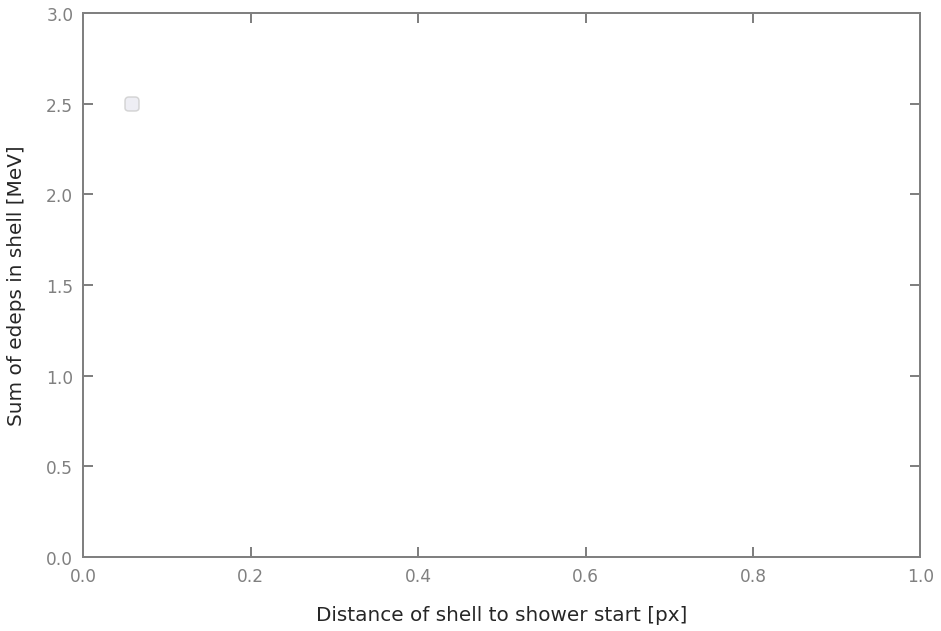

In [11]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = n_shells*delta_r
n_bins_x = n_shells
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Define binning
x_list = []
x_err_list = []
for i in range(n_bins_x):
    x_list.append((x_bins[i]+x_bins[i+1])/2.)
    x_err_list.append((x_bins[i+1]-x_bins[i])/2.)
print(' x_list:              ', x_list)
print(' x_err_list:          ', x_err_list)


# Obtain data
if len(electron_edep_sums)>0:
    mean_electrons     = np.mean(electron_edep_sums, axis=0)
    variance_electrons = np.var(electron_edep_sums, axis=0)
    print(' mean_electrons:      ', np.array(mean_electrons))
    print(' variance_electrons:  ', np.array(variance_electrons))
    
if len(photon_edep_sums)>0:
    mean_photons       = np.mean(photon_edep_sums, axis=0)
    variance_photons   = np.var(photon_edep_sums, axis=0)
    print(' mean_photons:        ', np.array(mean_photons))
    print(' variance_photons:    ', np.array(variance_photons))
    
if len(compton_edep_sums)>0:
    mean_comptons      = np.mean(compton_edep_sums, axis=0)
    variance_comptons  = np.var(compton_edep_sums, axis=0)
    print(' mean_comptons:       ', np.array(mean_comptons))
    print(' variance_comptons:   ', np.array(variance_comptons))

#mean_edep_electrons = np.mean(mean_electrons, axis=0)
#var_edep_electrons  = np.var(mean_electrons, axis=0)
#mean_edep_photons   = np.mean(mean_photons, axis=0)
#var_edep_photons    = np.var(mean_photons, axis=0)
#print(' mean_edep_electrons: ', np.array(mean_edep_electrons))
#print(' var_edep_electrons:  ', np.array(var_edep_electrons))
#print(' mean_edep_photons:   ', np.array(mean_edep_photons))
#print(' var_edep_photons:    ', np.array(var_edep_photons))

# Plot
if len(electron_edep_sums)>0:
    plt.errorbar(x_list, mean_electrons, xerr=x_err_list, yerr=np.sqrt(variance_electrons), label='electron induced showers', fmt='o', linewidth=3, color='r', alpha=0.8) #xerr=x_err_list, yerr=matching_eff_stdev
if len(photon_edep_sums)>0:
    plt.errorbar(x_list, mean_photons,   xerr=x_err_list, yerr=np.sqrt(variance_photons),   label='photon induced showers w/ and w/o compton',   fmt='x', linewidth=3, color='b', alpha=0.5) #xerr=x_err_list, yerr=matching_eff_stdev
if len(compton_edep_sums)>0:
    plt.errorbar(x_list, mean_comptons,   xerr=x_err_list, yerr=np.sqrt(variance_comptons), label='photon induced showers w/ compton',   fmt='x', linewidth=3, color='orange', alpha=0.5) #xerr=x_err_list, yerr=matching_eff_stdev


# Plot n_edeps
# Plot n_edeps
#n0, bins0, patches0 = plt.hist([n_edeps_reco_showers_all],                   label='all showers (no criteria)',   bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
#n1, bins1, patches1 = plt.hist([n_edeps_reco_showers_sep_mat_matched],       label='passed separation criterium', bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n2, bins2, patches2 = plt.hist([n_edeps_reco_showers_ang_mat_matched],       label='passed angle criterium',      bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n3, bins3, patches3 = plt.hist([n_edeps_reco_showers_overlap_mat_1_matched], label='passed overlap_1 criterium',  bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n4, bins4, patches4 = plt.hist([n_edeps_reco_showers_overlap_mat_2_matched], label='passed overlap_2 criterium',  bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n5, bins5, patches5 = plt.hist([n_edeps_reco_showers_overlap_mat_3_matched], label='passed overlap_3 criterium',  bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)

# Legend
plt.legend(loc=[0.05,0.82], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Distance of shell to shower start [px]', fontsize=20, labelpad=20)
plt.ylabel('Sum of edeps in shell [MeV]', fontsize=20, labelpad=20)

plt.ylim(bottom=0, top=3)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
#print(io_cfg)
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'edep_as_function_of_distance_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

No handles with labels found to put in legend.


 x_list:               [0.5, 1.5, 2.5, 3.5, 4.5]
 x_err_list:           [0.5, 0.5, 0.5, 0.5, 0.5]
 filename:  pi0_dunend_v1_p00
 fig_name:  n_hits_as_function_of_distance_5_shells_of_thickness_1px_40_events_from_file_pi0_dunend_v1_p00_root.png


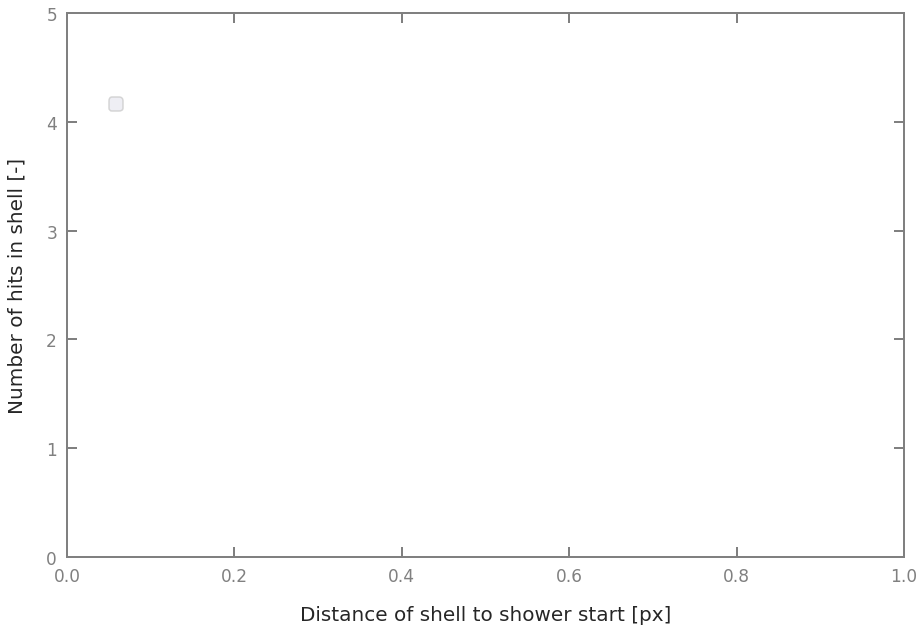

In [12]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = n_shells*delta_r
n_bins_x = n_shells
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Define binning
x_list = []
x_err_list = []
for i in range(n_bins_x):
    x_list.append((x_bins[i]+x_bins[i+1])/2.)
    x_err_list.append((x_bins[i+1]-x_bins[i])/2.)
print(' x_list:              ', x_list)
print(' x_err_list:          ', x_err_list)


# Obtain data
if len(electron_n_hits)>0:
    mean_electron_hits     = np.mean(electron_n_hits, axis=0)
    variance_electron_hits = np.var(electron_n_hits, axis=0)
    print(' mean_electrons_hit:      ', np.array(mean_electron_hits))
    print(' variance_electron_hits:  ', np.array(variance_electron_hits))
    
if len(photon_n_hits)>0:
    mean_photon_hits       = np.mean(photon_n_hits, axis=0)
    variance_photon_hits   = np.var(photon_n_hits, axis=0)
    print(' mean_photon_hits:        ', np.array(mean_photon_hits))
    print(' variance_photon_hits:    ', np.array(variance_photon_hits))
    
if len(compton_n_hits)>0:
    mean_compton_hits      = np.mean(compton_n_hits, axis=0)
    variance_compton_hits  = np.var(compton_n_hits, axis=0)
    print(' mean_compton_hits:       ', np.array(mean_compton_hits))
    print(' variance_compton_hits:   ', np.array(variance_compton_hits))


# Plot
if len(electron_n_hits)>0:
    plt.errorbar(x_list, mean_electron_hits, xerr=x_err_list, yerr=np.sqrt(variance_electron_hits), label='electron induced showers', fmt='o', linewidth=3, color='r', alpha=0.8) #xerr=x_err_list, yerr=matching_eff_stdev
if len(photon_n_hits)>0:
    plt.errorbar(x_list, mean_photon_hits,   xerr=x_err_list, yerr=np.sqrt(variance_photon_hits),   label='photon induced showers w/ and w/o compton',   fmt='x', linewidth=3, color='b', alpha=0.5) #xerr=x_err_list, yerr=matching_eff_stdev
if len(compton_n_hits)>0:
    plt.errorbar(x_list, mean_compton_hits,   xerr=x_err_list, yerr=np.sqrt(variance_compton_hits),   label='photon induced showers w/ compton',   fmt='x', linewidth=3, color='orange', alpha=0.5) #xerr=x_err_list, yerr=matching_eff_stdev


# Plot n_edeps
# Plot n_edeps
#n0, bins0, patches0 = plt.hist([n_edeps_reco_showers_all],                   label='all showers (no criteria)',   bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
#n1, bins1, patches1 = plt.hist([n_edeps_reco_showers_sep_mat_matched],       label='passed separation criterium', bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n2, bins2, patches2 = plt.hist([n_edeps_reco_showers_ang_mat_matched],       label='passed angle criterium',      bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n3, bins3, patches3 = plt.hist([n_edeps_reco_showers_overlap_mat_1_matched], label='passed overlap_1 criterium',  bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n4, bins4, patches4 = plt.hist([n_edeps_reco_showers_overlap_mat_2_matched], label='passed overlap_2 criterium',  bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)
#n5, bins5, patches5 = plt.hist([n_edeps_reco_showers_overlap_mat_3_matched], label='passed overlap_3 criterium',  bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.9)

# Legend
plt.legend(loc=[0.05,0.82], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Distance of shell to shower start [px]', fontsize=20, labelpad=20)
plt.ylabel('Number of hits in shell [-]', fontsize=20, labelpad=20)

plt.ylim(bottom=0, top=5)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
#print(io_cfg)
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'n_hits_as_function_of_distance_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [13]:
'''
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = n_shells*delta_r
n_bins_x = n_shells
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Define binning
x_list = []
x_err_list = []
for i in range(n_bins_x):
    x_list.append((x_bins[i]+x_bins[i+1])/2.)
    x_err_list.append((x_bins[i+1]-x_bins[i])/2.)
print(' x_list:              ', x_list)
print(' x_err_list:          ', x_err_list)


# Obtain data
#if len(electron_n_hits)>0:
    #print(electron_n_hits[0:3])
    #mean_electron_hits     = np.mean(electron_n_hits, axis=0)
    #variance_electron_hits = np.var(electron_n_hits, axis=0)
    #print(' mean_electrons_hit:      ', np.array(mean_electron_hits))
    #print(' variance_electron_hits:  ', np.array(variance_electron_hits))
    
#if len(photon_n_hits)>0:
    #mean_photon_hits       = np.mean(photon_n_hits, axis=0)
    #variance_photon_hits   = np.var(photon_n_hits, axis=0)
    #print(' mean_photon_hits:        ', np.array(mean_photon_hits))
    #print(' variance_photon_hits:    ', np.array(variance_photon_hits))
    
#if len(compton_n_hits)>0:
    #mean_compton_hits      = np.mean(compton_n_hits, axis=0)
    #variance_compton_hits  = np.var(compton_n_hits, axis=0)
    #print(' mean_compton_hits:       ', np.array(mean_compton_hits))
    #print(' variance_compton_hits:   ', np.array(variance_compton_hits))
    
#if len(electron_edep_sums)>0:
    #mean_electron_edep     = np.mean(electron_edep_sums, axis=0)
    #variance_electron_edep = np.var(electron_edep_sums, axis=0)
    #print(' mean_electron_edep:      ', np.array(mean_electron_edep))
    #print(' variance_electron_edep:  ', np.array(variance_electron_edep))
    
#if len(photon_edep_sums)>0:
    #mean_photon_edep     = np.mean(photon_edep_sums, axis=0)
    #variance_photon_edep = np.var(photon_edep_sums, axis=0)
    #print(' mean_photon_edep:        ', np.array(mean_photon_edep))
    #print(' variance_photon_edep:    ', np.array(variance_photon_edep))
    
#if len(compton_edep_sums)>0:
    #mean_compton_edep     = np.mean(compton_edep_sums, axis=0)
    #variance_compton_edep = np.var(compton_edep_sums, axis=0)
    #print(' mean_compton_edep:       ', np.array(mean_compton_edep))
    #print(' variance_compton_edep:   ', np.array(variance_compton_edep))
    
_electron_summed_dE = np.sum(electron_edep_sums[0:4],axis=0)
print(' _electron_summed_dE: ', _electron_summed_dE)
_electron_summed_dn = np.sum(electron_n_hits[0:4],axis=0)
print(' _electron_summed_dn: ', _electron_summed_dn)
mean_electron_dE_dn = np.array(_electron_summed_dE) / np.array(_electron_summed_dn)
print(' mean_electron_dE_dn: ', mean_electron_dE_dn)

_photon_summed_dE = np.sum(photon_edep_sums[0:4],axis=0)
print(' _photon_summed_dE: ', _photon_summed_dE)
_photon_summed_dn = np.sum(photon_n_hits[0:4],axis=0)
print(' _photon_summed_dn: ', _photon_summed_dn)
mean_photon_dE_dn = np.array(_photon_summed_dE) / np.array(_photon_summed_dn)
print(' mean_photon_dE_dn: ', mean_photon_dE_dn)

_compton_summed_dE = np.sum(compton_edep_sums[0:4],axis=0)
print(' _compton_summed_dE: ', _compton_summed_dE)
_compton_summed_dn = np.sum(compton_n_hits[0:4],axis=0)
print(' _compton_summed_dn: ', _compton_summed_dn)
mean_compton_dE_dn = np.array(_compton_summed_dE) / np.array(_compton_summed_dn)
print(' mean_compton_dE_dn: ', mean_compton_dE_dn)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@     VARIANCE OF BINS NOT YET IMPLEMENTED!!      @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Plot
if len(electron_n_hits)>0:
    plt.errorbar(x_list, mean_electron_dE_dn, xerr=x_err_list, yerr=np.sqrt([0.1]), label='electron induced showers', fmt='o', linewidth=3, color='r', alpha=0.8) #xerr=x_err_list, yerr=matching_eff_stdev
if len(photon_n_hits)>0:
    plt.errorbar(x_list, mean_photon_dE_dn,   xerr=x_err_list, yerr=np.sqrt([0.1]),   label='photon induced showers w/ and w/o compton',   fmt='x', linewidth=3, color='b', alpha=0.5) #xerr=x_err_list, yerr=matching_eff_stdev
if len(compton_n_hits)>0:
    plt.errorbar(x_list, mean_compton_dE_dn,   xerr=x_err_list, yerr=np.sqrt([0.1]),   label='photon induced showers w/ compton',   fmt='x', linewidth=3, color='orange', alpha=0.5) #xerr=x_err_list, yerr=matching_eff_stdev

# Legend
plt.legend(loc=[0.05,0.82], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Distance of shell to shower start [px]', fontsize=20, labelpad=20)
plt.ylabel('dE/dN in shell [MeV]', fontsize=20, labelpad=20)

plt.ylim(bottom=0, top=5)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
#print(io_cfg)
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'dE_dn_as_function_of_distance_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'
'''

"\nimport pandas as pd\nimport seaborn\nfrom matplotlib import pyplot as plt\n\nseaborn.set(rc={'figure.figsize':(15, 10),})\nseaborn.set_context('talk') # or paper\n\n# Define histogram range and binning\nx_min    = 0\nx_max    = n_shells*delta_r\nn_bins_x = n_shells\nx_bins = np.linspace(x_min,x_max,n_bins_x+1)\n\n# Define parameters of the frame\nfig = plt.figure() # plt.figure(figsize=(width,height))\n#fig.patch.set_facecolor('white')\n#fig.patch.set_alpha(0.0)\nax = fig.add_subplot(111)\n#ax.patch.set_facecolor('#ababab') # #ababab\nax.patch.set_alpha(0.0)\nax.spines['bottom'].set_color('0.5') #'black', ...\nax.spines['bottom'].set_linewidth(2)\nax.spines['bottom'].set_visible(True)\nax.spines['top'].set_color('0.5')\nax.spines['top'].set_linewidth(2)\nax.spines['top'].set_visible(True)\nax.spines['right'].set_color('0.5')\nax.spines['right'].set_linewidth(2)\nax.spines['right'].set_visible(True)\nax.spines['left'].set_color('0.5')\nax.spines['left'].set_linewidth(2)\nax.spines['l

NameError: name 'bin_edges0' is not defined

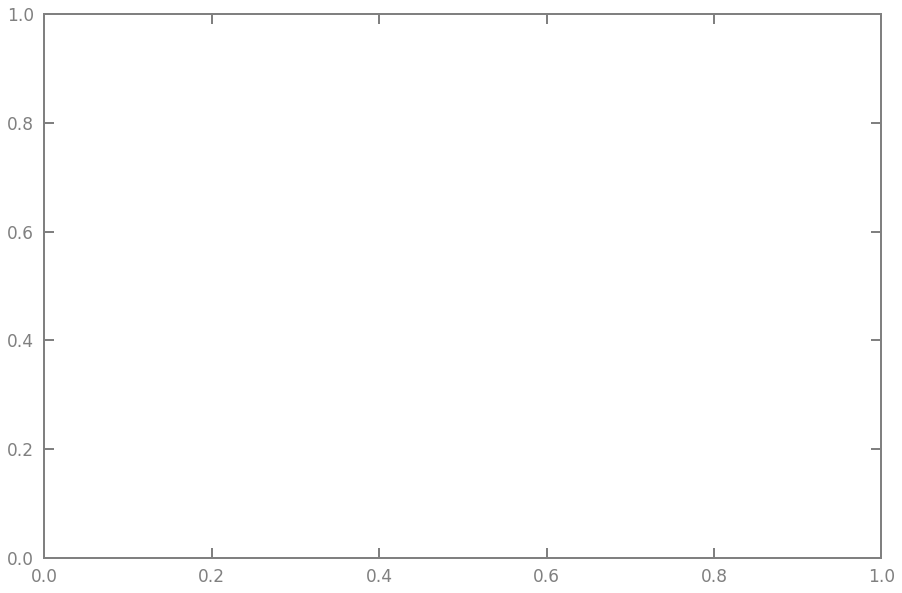

In [14]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 10
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Obtain data (here: particle-wise; meaning: sum up all dE/dx values of all shells from a particle, put it to histogram, and then go to next particle)
if len(electron_dE_dx)>0:
    mean_electrons     = np.mean(electron_dE_dx, axis=1)
    #variance_electrons = np.var(electron_edep_sums, axis=0)
    #print(' mean_electrons:      ', np.array(mean_electrons))
    #print(' variance_electrons:  ', np.array(variance_electrons))
if len(photon_dE_dx)>0:
    mean_photons       = np.mean(photon_dE_dx, axis=1)
    #variance_photons   = np.var(photon_edep_sums, axis=0)
    #print(' mean_photons:        ', np.array(mean_photons))
    #print(' variance_photons:    ', np.array(variance_photons))
if len(compton_dE_dx)>0:
    mean_comptons       = np.mean(compton_dE_dx, axis=1)
    #variance_comptons   = np.var(compton_edep_sums, axis=0)
    #print(' mean_compons:        ', np.array(mean_comptons))
    #print(' variance_comptons:   ', np.array(variance_comptons))

#mean_edep_electrons = np.mean(mean_electrons, axis=0)
#var_edep_electrons  = np.var(mean_electrons, axis=0)
#mean_edep_photons   = np.mean(mean_photons, axis=0)
#var_edep_photons    = np.var(mean_photons, axis=0)
#mean_edep_comptons   = np.mean(mean_comptons, axis=0)
#var_edep_comptons    = np.var(mean_comptons, axis=0)
#print(' mean_edep_electrons: ', np.array(mean_edep_electrons))
#print(' var_edep_electrons:  ', np.array(var_edep_electrons))
#print(' mean_edep_photons:   ', np.array(mean_edep_photons))
#print(' var_edep_photons:    ', np.array(var_edep_photons))
#print(' mean_edep_comptons:   ', np.array(mean_edep_comptons))
#print(' var_edep_comptons:    ', np.array(var_edep_comptons))

# Plot
if len(electron_dE_dx)>0:
    entries0, bin_edges0, patches0 = plt.hist([mean_electrons], label='Electron induced showers',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='r', stacked=False, linewidth=3, alpha=0.5)
if len(photon_dE_dx)>0:
    entries1, bin_edges1, patches1 = plt.hist([mean_photons],   label='Photon induced showers w/ and w/o compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='b', stacked=False, linewidth=3, alpha=0.5)
if len(compton_dE_dx)>0:
    entries2, bin_edges2, patches2 = plt.hist([mean_comptons],  label='Photon induced showers w/ compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='step', color='orange',       stacked=False, linewidth=3, alpha=0.9)


bin_middles = 0.5 * (bin_edges0[1:] + bin_edges0[:-1])


# Define fit functions
def gaus(x, a, mu, sigma):
    return  a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2./np.pi)/sigma

def moyal(x, scale_up, shift, squeeze_x):
    return scale_up * 1./(np.sqrt(2.*np.pi)) * np.exp(-0.5*((squeeze_x*x-shift)+np.exp(-(squeeze_x*x-shift))))


def parabola(x, a, b, c):
    return a*(x-b)**2 + c

#def landau_integrand(x, mu, c):
#    from scipy import integrate
#    res = []
#    for ind, x in enumerate(x):
#        fn = lambda t : np.exp(-t)*np.cos(t*(x-mu)/c + 2.*t/np.pi*np.log(t/c))
#        #fn = lambda t : 1./np.pi * np.exp(-t*np.log(t)-x*t)*np.sin(np.pi*t)
#        #print(' fn: ', fn)
#        res.append(integrate.quad(fn, 0., 1000.)[0])
#    #res = np.asarray([integrate.quad(fn, 0., 100.)[0] for _x in x])
#    #print(' res: ', res)
#    return res

#def landau(x, mu, c):
#    integral = landau_integrand(x, mu, c)
#    result = 1./(np.pi*c) * np.array(integral)
#    return result
#    #return integral


print(' Gaussian fit: ')
popt_gauss_0_dE_dx, pcov_gauss_0_dE_dx = curve_fit(gaus, bin_middles, entries0) #, p0=(100, 100, 10))
print(' \n Gaussian fitted parameters for electron induced showers: ',
      ' \n a [-]: \t ', popt_gauss_0_dE_dx[0],
      ' \n \u03BC [MeV/c2]: \t ', popt_gauss_0_dE_dx[1],
      ' \n \u03C3 [MeV/c2]: \t ', popt_gauss_0_dE_dx[2])

popt_gauss_1_dE_dx, pcov_gauss_1_dE_dx = curve_fit(gaus, bin_middles, entries1) #, p0=(100, 100, 10))
print(' \n Gaussian fitted parameters for photon induced showers: ',
      ' \n a [-]: \t ', popt_gauss_1_dE_dx[0],
      ' \n \u03BC [MeV/c2]: \t ', popt_gauss_1_dE_dx[1],
      ' \n \u03C3 [MeV/c2]: \t ', popt_gauss_1_dE_dx[2])

print(' Moyal fit: ')
popt_moyal_0_dE_dx, pcov_moyal_0_dE_dx = curve_fit(moyal, bin_middles, entries0)
print(' \n Moyal fitted parameters for electron induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_0_dE_dx[0],
      ' \n shift in x [-]:   \t ', popt_moyal_0_dE_dx[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_0_dE_dx[2])
popt_moyal_1_dE_dx, pcov_moyal_1_dE_dx = curve_fit(moyal, bin_middles, entries1)
print(' \n Moyal fitted parameters for photon induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_1_dE_dx[0],
      ' \n shift in x [-]:   \t ', popt_moyal_1_dE_dx[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_1_dE_dx[2])

#print(' Parabola fit: ')
#popt_parabola_dE_dx, pcov_parabola_dE_dx = curve_fit(parabola, bin_middles, entries1)
#print(' \n Parabola fitted parameters for electron induced showers: ',
#      ' \n a [?]: \t ', popt_parabola_dE_dx[0],
#      ' \n b [?]: \t ', popt_parabola_dE_dx[1],
#      ' \n c [?]: \t ', popt_parabola_dE_dx[2])

#print(' Landau fit: ')
#popt_landau_dE_dx, pcov_landau_dE_dx = curve_fit(landau, bin_middles, entries1, p0=(2, 35))
#print(' \n Landau fitted parameters for electron induced showers: ',
#      ' \n mu [?]: \t ', popt_landau_dE_dx[0],
#      ' \n c [?]: \t ', popt_landau_dE_dx[1])


# Fit for every bin a single point
x0_points = bin_middles
x1_points = bin_middles
y0_gauss_points = gaus(x0_points, popt_gauss_0_dE_dx[0], popt_gauss_0_dE_dx[1], popt_gauss_0_dE_dx[2])
y1_gauss_points = gaus(x1_points, popt_gauss_1_dE_dx[0], popt_gauss_1_dE_dx[1], popt_gauss_1_dE_dx[2])
y0_moyal_points = moyal(x0_points, popt_moyal_0_dE_dx[0], popt_moyal_0_dE_dx[1], popt_moyal_0_dE_dx[2])
y1_moyal_points = moyal(x1_points, popt_moyal_1_dE_dx[0], popt_moyal_1_dE_dx[1], popt_moyal_1_dE_dx[2])

# Fit an 'interpolated' line
x0_fine = np.linspace(x_min,x_max,200)
x1_fine = np.linspace(x_min,x_max,200)
y0_gauss_fine = gaus(x0_fine, popt_gauss_0_dE_dx[0], popt_gauss_0_dE_dx[1], popt_gauss_0_dE_dx[2])
y1_gauss_fine = gaus(x1_fine, popt_gauss_1_dE_dx[0], popt_gauss_1_dE_dx[1], popt_gauss_1_dE_dx[2])
y0_moyal_fine = moyal(x0_fine, popt_moyal_0_dE_dx[0], popt_moyal_0_dE_dx[1], popt_moyal_0_dE_dx[2])
y1_moyal_fine = moyal(x1_fine, popt_moyal_1_dE_dx[0], popt_moyal_1_dE_dx[1], popt_moyal_1_dE_dx[2])
#y_parabola_fine = parabola(x0_fine, popt_parabola_dE_dx[0], popt_parabola_dE_dx[1], popt_parabola_dE_dx[2])
#y_landau_fine = landau(x0_fine, popt_landau_dE_dx[0], popt_landau_dE_dx[1])

# Plot points
#plt.plot(x0_fine, y0_gauss_fine, linestyle='dashed', color='r', marker='', linewidth=3, alpha=0.8)#, label='Gaussian fit')
#plt.plot(x1_fine, y1_gauss_fine, linestyle='dashed', color='b', marker='', linewidth=3, alpha=0.8)#, label='Gaussian fit')
plt.plot(x0_fine, y0_moyal_fine, linestyle='--', color='r', marker='', label='Moyal fit for electron induced showers', linewidth=3, alpha=0.8)
plt.plot(x1_fine, y1_moyal_fine, linestyle='--', color='b', marker='', label='Moyal fit for photon induced showers', linewidth=3, alpha=0.8)
#plt.plot(x0_fine, y_parabola_fine, linestyle='', color='orange', marker='x', label='Parabola fit', linewidth=3, alpha=0.8)
#plt.plot(x0_fine, y_landau_fine, linestyle='', color='magenta', marker='x', label='Landau fit', linewidth=3, alpha=0.8)

# Plot dashed (interpolated) lines
#plt.plot(x0_points, y0_gauss_points, linestyle='', color='r', marker='o', label='Gaussian fit: \u03BC=%5.3f, \u03C3=%5.3f' % (popt_gauss_0_dE_dx[1], popt_gauss_0_dE_dx[2]))
#plt.plot(x1_points, y1_gauss_points, linestyle='', color='b', marker='o', label='Gaussian fit: \u03BC=%5.3f, \u03C3=%5.3f' % (popt_gauss_1_dE_dx[1], popt_gauss_1_dE_dx[2]))
#plt.plot(x0_points, y0_moyal_points, linestyle='', color='r', marker='o')#, label='Moyal fit for electron induced showers')
#plt.plot(x1_points, y1_moyal_points, linestyle='', color='b', marker='o')#, label='Moyal fit for photon induced showers')


# Legend
plt.legend(loc=[0.43,0.7], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('dE/dx [MeV/cm]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=20)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' \n filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'dE_dx_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [ ]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 20
n_bins_x = 40
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Obtain data (here: particle-wise; meaning: sum up all dE/dx values of all shells from a particle, put it to histogram, and then go to next particle)
if len(electron_dn_dx)>0:
    mean_electrons     = np.mean(electron_dn_dx, axis=1)
if len(photon_dn_dx)>0:
    mean_photons       = np.mean(photon_dn_dx, axis=1)
if len(compton_dn_dx)>0:
    mean_comptons       = np.mean(compton_dn_dx, axis=1)

# Plot
if len(electron_dn_dx)>0:
    entries0, bin_edges0, patches0 = plt.hist([mean_electrons], label='Electron induced showers',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='r', stacked=False, linewidth=3, alpha=0.5)
if len(photon_dn_dx)>0:
    entries1, bin_edges1, patches1 = plt.hist([mean_photons],   label='Photon induced showers w/ and w/o compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='b', stacked=False, linewidth=3, alpha=0.5)
if len(compton_dn_dx)>0:
    entries2, bin_edges2, patches2 = plt.hist([mean_comptons],  label='Photon induced showers w/ compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='step', color='orange',       stacked=False, linewidth=3, alpha=0.9)


bin_middles = 0.5 * (bin_edges0[1:] + bin_edges0[:-1])

# Define fit function
def moyal(x, scale_up, shift, squeeze_x):
    return scale_up * 1./(np.sqrt(2.*np.pi)) * np.exp(-0.5*((squeeze_x*x-shift)+np.exp(-(squeeze_x*x-shift))))

print(' Moyal fit: ')
popt_moyal_0_dn_dx, pcov_moyal_0_dn_dx = curve_fit(moyal, bin_middles, entries0)
print(' \n Moyal fitted parameters for electron induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_0_dn_dx[0],
      ' \n shift in x [-]:   \t ', popt_moyal_0_dn_dx[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_0_dn_dx[2])
popt_moyal_1_dn_dx, pcov_moyal_1_dn_dx = curve_fit(moyal, bin_middles, entries1)
print(' \n Moyal fitted parameters for photon induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_1_dn_dx[0],
      ' \n shift in x [-]:   \t ', popt_moyal_1_dn_dx[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_1_dn_dx[2])

# Fit for every bin a single point
x0_points = bin_middles
x1_points = bin_middles
y0_moyal_points = moyal(x0_points, popt_moyal_0_dn_dx[0], popt_moyal_0_dn_dx[1], popt_moyal_0_dn_dx[2])
y1_moyal_points = moyal(x1_points, popt_moyal_1_dn_dx[0], popt_moyal_1_dn_dx[1], popt_moyal_1_dn_dx[2])

# Fit an 'interpolated' line
x0_fine = np.linspace(x_min,x_max,200)
x1_fine = np.linspace(x_min,x_max,200)
y0_moyal_fine = moyal(x0_fine, popt_moyal_0_dn_dx[0], popt_moyal_0_dn_dx[1], popt_moyal_0_dn_dx[2])
y1_moyal_fine = moyal(x1_fine, popt_moyal_1_dn_dx[0], popt_moyal_1_dn_dx[1], popt_moyal_1_dn_dx[2])

# Plot points
plt.plot(x0_fine, y0_moyal_fine, linestyle='--', color='r', marker='', label='Moyal fit for electron induced showers', linewidth=3, alpha=0.8)
plt.plot(x1_fine, y1_moyal_fine, linestyle='--', color='b', marker='', label='Moyal fit for photon induced showers', linewidth=3, alpha=0.8)


# Legend
plt.legend(loc=[0.43,0.7], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('dn/dx [MeV/cm]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=20)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' \n filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'dn_dx_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [ ]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 2
n_bins_x = 40
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Obtain data (here: particle-wise; meaning: sum up all dE/dx values of all shells from a particle, put it to histogram, and then go to next particle)
if len(electron_dE_dn)>0:
    mean_electrons     = np.mean(electron_dE_dn, axis=1)
if len(photon_dE_dn)>0:
    mean_photons       = np.mean(photon_dE_dn, axis=1)
if len(compton_dE_dn)>0:
    mean_comptons       = np.mean(compton_dE_dn, axis=1)

# Plot
if len(electron_dE_dn)>0:
    entries0, bin_edges0, patches0 = plt.hist([mean_electrons], label='Electron induced showers',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='r', stacked=False, linewidth=3, alpha=0.5)
if len(photon_dE_dn)>0:
    entries1, bin_edges1, patches1 = plt.hist([mean_photons],   label='Photon induced showers w/ and w/o compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='b', stacked=False, linewidth=3, alpha=0.5)
if len(compton_dE_dn)>0:
    entries2, bin_edges2, patches2 = plt.hist([mean_comptons],  label='Photon induced showers w/ compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='step', color='orange',       stacked=False, linewidth=3, alpha=0.9)


bin_middles = 0.5 * (bin_edges0[1:] + bin_edges0[:-1])

# Define fit function
def moyal(x, scale_up, shift, squeeze_x):
    return scale_up * 1./(np.sqrt(2.*np.pi)) * np.exp(-0.5*((squeeze_x*x-shift)+np.exp(-(squeeze_x*x-shift))))

print(' Moyal fit: ')
popt_moyal_0_dE_dn, pcov_moyal_0_dE_dn = curve_fit(moyal, bin_middles, entries0)
print(' \n Moyal fitted parameters for electron induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_0_dE_dn[0],
      ' \n shift in x [-]:   \t ', popt_moyal_0_dE_dn[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_0_dE_dn[2])
popt_moyal_1_dE_dn, pcov_moyal_1_dE_dn = curve_fit(moyal, bin_middles, entries1)
print(' \n Moyal fitted parameters for photon induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_1_dE_dn[0],
      ' \n shift in x [-]:   \t ', popt_moyal_1_dE_dn[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_1_dE_dn[2])

# Fit for every bin a single point
x0_points = bin_middles
x1_points = bin_middles
y0_moyal_points = moyal(x0_points, popt_moyal_0_dE_dn[0], popt_moyal_0_dE_dn[1], popt_moyal_0_dE_dn[2])
y1_moyal_points = moyal(x1_points, popt_moyal_1_dE_dn[0], popt_moyal_1_dE_dn[1], popt_moyal_1_dE_dn[2])

# Fit an 'interpolated' line
x0_fine = np.linspace(x_min,x_max,200)
x1_fine = np.linspace(x_min,x_max,200)
y0_moyal_fine = moyal(x0_fine, popt_moyal_0_dE_dn[0], popt_moyal_0_dE_dn[1], popt_moyal_0_dE_dn[2])
y1_moyal_fine = moyal(x1_fine, popt_moyal_1_dE_dn[0], popt_moyal_1_dE_dn[1], popt_moyal_1_dE_dn[2])

# Plot points
plt.plot(x0_fine, y0_moyal_fine, linestyle='--', color='r', marker='', label='Moyal fit for electron induced showers', linewidth=3, alpha=0.8)
plt.plot(x1_fine, y1_moyal_fine, linestyle='--', color='b', marker='', label='Moyal fit for photon induced showers', linewidth=3, alpha=0.8)


# Legend
plt.legend(loc=[0.43,0.7], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('dE/dn [MeV]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=20)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' \n filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'dE_dn_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [ ]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 6
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Obtain data (here: particle-wise; meaning: take n_hits of all shells from a particle, put it to histogram, and then go to next particle)

if len(electron_n_hits)>0:
    mean_hits_electrons     = np.mean(electron_n_hits, axis=1)
    #print(' mean_hits_electrons: ', np.array(mean_hits_electrons))
if len(photon_n_hits)>0:
    mean_hits_photons       = np.mean(photon_n_hits, axis=1)
    #print(' mean_hits_photons:   ', np.array(mean_hits_photons))
if len(compton_n_hits)>0:
    mean_hits_comptons      = np.mean(compton_n_hits, axis=1)
    #print(' mean_hits_comptons:  ', np.array(mean_hits_comptons))

# Plot
if len(electron_n_hits)>0:
    entries0, bin_edges0, patches0 = plt.hist([mean_hits_electrons], label='Electron induced showers',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='r', stacked=False, linewidth=3, alpha=0.5)
if len(photon_n_hits)>0:
    entries1, bin_edges1, patches1 = plt.hist([mean_hits_photons],   label='Photon induced showers w/ and w/o compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='b', stacked=False, linewidth=3, alpha=0.5)
if len(compton_n_hits)>0:
    entries2, bin_edges2, patches2 = plt.hist([mean_hits_comptons],  label='Photon induced showers w/ compton',\
                                              bins=n_bins_x, range=[x_min,x_max], histtype='step',       color='orange', stacked=False, linewidth=3, alpha=0.9)


bin_middles = 0.5 * (bin_edges0[1:] + bin_edges0[:-1])


# Define fit functions
def gaus(x, a, mu, sigma):
    return  a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2./np.pi)/sigma

def moyal(x, scale_up, shift, squeeze_x):
    return scale_up * 1./(np.sqrt(2.*np.pi)) * np.exp(-0.5*((squeeze_x*x-shift)+np.exp(-(squeeze_x*x-shift))))

def parabola(x, a, b, c):
    return a*(x-b)**2 + c

#def landau_integrand(x, mu, c):
#    from scipy import integrate
#    res = []
#    for ind, x in enumerate(x):
#        fn = lambda t : np.exp(-t)*np.cos(t*(x-mu)/c + 2.*t/np.pi*np.log(t/c))
#        #fn = lambda t : 1./np.pi * np.exp(-t*np.log(t)-x*t)*np.sin(np.pi*t)
#        #print(' fn: ', fn)
#        res.append(integrate.quad(fn, 0., 1000.)[0])
#    #res = np.asarray([integrate.quad(fn, 0., 100.)[0] for _x in x])
#    #print(' res: ', res)
#    return res

#def landau(x, mu, c):
#    integral = landau_integrand(x, mu, c)
#    result = 1./(np.pi*c) * np.array(integral)
#    return result
#    #return integral


print(' Gaussian fit: ')
popt_gauss_0_n_hits, pcov_gauss_0_n_hits = curve_fit(gaus, bin_middles, entries0) #, p0=(100, 100, 10))
print(' \n Gaussian fitted parameters for electron induced showers: ',
      ' \n a [-]: \t ', popt_gauss_0_n_hits[0],
      ' \n \u03BC [MeV/c2]: \t ', popt_gauss_0_n_hits[1],
      ' \n \u03C3 [MeV/c2]: \t ', popt_gauss_0_n_hits[2])

popt_gauss_1_n_hits, pcov_gauss_1_n_hits = curve_fit(gaus, bin_middles, entries1) #, p0=(100, 100, 10))
print(' \n Gaussian fitted parameters for photon induced showers: ',
      ' \n a [-]: \t ', popt_gauss_1_n_hits[0],
      ' \n \u03BC [MeV/c2]: \t ', popt_gauss_1_n_hits[1],
      ' \n \u03C3 [MeV/c2]: \t ', popt_gauss_1_n_hits[2])

print(' Moyal fit: ')
popt_moyal_0_n_hits, pcov_moyal_0_n_hits = curve_fit(moyal, bin_middles, entries0)
print(' \n Moyal fitted parameters for electron induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_0_n_hits[0],
      ' \n shift in x [-]:   \t ', popt_moyal_0_n_hits[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_0_n_hits[2])
popt_moyal_1_n_hits, pcov_moyal_1_n_hits = curve_fit(moyal, bin_middles, entries1)
print(' \n Moyal fitted parameters for photon induced showers: ',
      ' \n scale_up [-]:     \t ', popt_moyal_1_n_hits[0],
      ' \n shift in x [-]:   \t ', popt_moyal_1_n_hits[1],
      ' \n squeeze in x [-]: \t ', popt_moyal_1_n_hits[2])

#print(' Parabola fit: ')
#popt_parabola_n_hits, pcov_parabola_n_hits = curve_fit(parabola, bin_middles, entries1)
#print(' \n Parabola fitted parameters for electron induced showers: ',
#      ' \n a [?]: \t ', popt_parabola_n_hits[0],
#      ' \n b [?]: \t ', popt_parabola_n_hits[1],
#      ' \n c [?]: \t ', popt_parabola_n_hits[2])

#print(' Landau fit: ')
#popt_landau_n_hits, pcov_landau_n_hits = curve_fit(landau, bin_middles, entries1, p0=(2, 35))
#print(' \n Landau fitted parameters for electron induced showers: ',
#      ' \n mu [?]: \t ', popt_landau_n_hits[0],
#      ' \n c [?]: \t ', popt_landau_n_hits[1])


# Fit for every bin a single point
x0_points = bin_middles
x1_points = bin_middles
y0_gauss_points = gaus(x0_points, popt_gauss_0_n_hits[0], popt_gauss_0_n_hits[1], popt_gauss_0_n_hits[2])
y1_gauss_points = gaus(x1_points, popt_gauss_1_n_hits[0], popt_gauss_1_n_hits[1], popt_gauss_1_n_hits[2])
y0_moyal_points = moyal(x0_points, popt_moyal_0_n_hits[0], popt_moyal_0_n_hits[1], popt_moyal_0_n_hits[2])
y1_moyal_points = moyal(x1_points, popt_moyal_1_n_hits[0], popt_moyal_1_n_hits[1], popt_moyal_1_n_hits[2])

# Fit an 'interpolated' line
x0_fine = np.linspace(x_min,x_max,200)
x1_fine = np.linspace(x_min,x_max,200)
y0_gauss_fine = gaus(x0_fine, popt_gauss_0_n_hits[0], popt_gauss_0_n_hits[1], popt_gauss_0_n_hits[2])
y1_gauss_fine = gaus(x1_fine, popt_gauss_1_n_hits[0], popt_gauss_1_n_hits[1], popt_gauss_1_n_hits[2])
y0_moyal_fine = moyal(x0_fine, popt_moyal_0_n_hits[0], popt_moyal_0_n_hits[1], popt_moyal_0_n_hits[2])
y1_moyal_fine = moyal(x1_fine, popt_moyal_1_n_hits[0], popt_moyal_1_n_hits[1], popt_moyal_1_n_hits[2])
#y_parabola_fine = parabola(x0_fine, popt_parabola_n_hits[0], popt_parabola_n_hits[1], popt_parabola_n_hits[2])
#y_landau_fine = landau(x0_fine, popt_landau_n_hits[0], popt_landau_n_hits[1])

# Plot points
#plt.plot(x0_fine, y0_gauss_fine, linestyle='dashed', color='r', marker='', linewidth=3, alpha=0.8)#, label='Gaussian fit')
#plt.plot(x1_fine, y1_gauss_fine, linestyle='dashed', color='b', marker='', linewidth=3, alpha=0.8)#, label='Gaussian fit')
plt.plot(x0_fine, y0_moyal_fine, linestyle='--', color='r', marker='', label='Moyal fit for electron induced showers', linewidth=3, alpha=0.8)
plt.plot(x1_fine, y1_moyal_fine, linestyle='--', color='b', marker='', label='Moyal fit for photon induced showers', linewidth=3, alpha=0.8)
#plt.plot(x0_fine, y_parabola_fine, linestyle='', color='orange', marker='x', label='Parabola fit', linewidth=3, alpha=0.8)
#plt.plot(x0_fine, y_landau_fine, linestyle='', color='magenta', marker='x', label='Landau fit', linewidth=3, alpha=0.8)

# Plot dashed (interpolated) lines
#plt.plot(x0_points, y0_gauss_points, linestyle='', color='r', marker='o', label='Gaussian fit: \u03BC=%5.3f, \u03C3=%5.3f' % (popt_gauss_0_n_hits[1], popt_gauss_0_n_hits[2]))
#plt.plot(x1_points, y1_gauss_points, linestyle='', color='b', marker='o', label='Gaussian fit: \u03BC=%5.3f, \u03C3=%5.3f' % (popt_gauss_1_n_hits[1], popt_gauss_1_n_hits[2]))
#plt.plot(x0_points, y0_moyal_points, linestyle='', color='r', marker='o')#, label='Moyal fit for electron induced showers')
#plt.plot(x1_points, y1_moyal_points, linestyle='', color='b', marker='o')#, label='Moyal fit for photon induced showers')


# Legend
plt.legend(loc=[0.43,0.7], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Number of hits [-]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=20)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' \n filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'n_hits_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

# Likelihood and likelihood fraction, based on
- assumption that dE/dx is distributed gaussian (NOT USED ANYMORE)
- assumption that dE/dx is distributed according to the moyal distribution (approximated landau)

In [ ]:
# Define weighting functions (probability of having electrons and photons in the sample)
P_electron = 1.0
P_photon   = 1.0

import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 10
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Define an array of measurements (here: uniformly distributed)
dE_dx_meas = np.linspace(x_min,x_max,200) # bin_middles
#print(' dE_dx_meas: ', dE_dx_meas)

# Define likelihood and likelihood fractions (according to fitted functions)
## This is for the gauss fits:
L_electron = gaus(dE_dx_meas, popt_gauss_0_dE_dx[0], popt_gauss_0_dE_dx[1], popt_gauss_0_dE_dx[2])
L_photon   = gaus(dE_dx_meas, popt_gauss_1_dE_dx[0], popt_gauss_1_dE_dx[1], popt_gauss_1_dE_dx[2])
L_electron_fraction = np.array(L_electron)*P_electron / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
L_photon_fraction   = np.array(L_photon)  *P_photon   / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
## This is for the moyal fits:
L_electron = moyal(dE_dx_meas, popt_moyal_0_dE_dx[0], popt_moyal_0_dE_dx[1], popt_moyal_0_dE_dx[2])
L_photon   = moyal(dE_dx_meas, popt_moyal_1_dE_dx[0], popt_moyal_1_dE_dx[1], popt_moyal_1_dE_dx[2])
L_electron_fraction = np.array(L_electron)*P_electron / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
L_photon_fraction   = np.array(L_photon)  *P_photon   / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )

#print(' L_electron: ', L_electron)
#print(' L_photon:   ', L_photon)
#print(' L_electron_fraction: ', L_electron_fraction)
#print(' L_photon_fraction:   ', L_photon_fraction)


#Plot
plt.errorbar(dE_dx_meas, L_electron_fraction, fmt='', color='r', linestyle='--', alpha=0.8, label='Electron induced shower',  linewidth=3)
plt.errorbar(dE_dx_meas, L_photon_fraction,   fmt='', color='b', linestyle='--', alpha=0.8, label='Photon induced shower',    linewidth=3)


# Legend
plt.legend(loc=[0.6,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('dE/dx [MeV/cm]', fontsize=20, labelpad=20)
plt.ylabel('Likelihood fraction [-]', fontsize=20, labelpad=20)

plt.xlim(x_max-1.05*(x_max-x_min),1.05*(x_max-x_min))
#plt.ylim(bottom=0, top=260)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'likelihood_fractions_dE_dx_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [ ]:
# Define weighting functions (probability of having electrons and photons in the sample)
P_electron = 1.0
P_photon   = 1.0

import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 20
n_bins_x = 40
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Define an array of measurements (here: uniformly distributed)
dn_dx_meas = np.linspace(x_min,x_max,200) # bin_middles
#print(' dn_dx_meas: ', dn_dx_meas)

# Define likelihood and likelihood fractions (according to fitted functions)
L_electron = moyal(dn_dx_meas, popt_moyal_0_dn_dx[0], popt_moyal_0_dn_dx[1], popt_moyal_0_dn_dx[2])
L_photon   = moyal(dn_dx_meas, popt_moyal_1_dn_dx[0], popt_moyal_1_dn_dx[1], popt_moyal_1_dn_dx[2])
L_electron_fraction = np.array(L_electron)*P_electron / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
L_photon_fraction   = np.array(L_photon)  *P_photon   / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )

#print(' L_electron: ', L_electron)
#print(' L_photon:   ', L_photon)
#print(' L_electron_fraction: ', L_electron_fraction)
#print(' L_photon_fraction:   ', L_photon_fraction)


#Plot
plt.errorbar(dn_dx_meas, L_electron_fraction, fmt='', color='r', linestyle='--', alpha=0.8, label='Electron induced shower',  linewidth=3)
plt.errorbar(dn_dx_meas, L_photon_fraction,   fmt='', color='b', linestyle='--', alpha=0.8, label='Photon induced shower',    linewidth=3)


# Legend
plt.legend(loc=[0.6,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('dn/dx [MeV/cm]', fontsize=20, labelpad=20)
plt.ylabel('Likelihood fraction [-]', fontsize=20, labelpad=20)

plt.xlim(x_max-1.05*(x_max-x_min),1.05*(x_max-x_min))
#plt.ylim(bottom=0, top=260)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'likelihood_fractions_dn_dx_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [ ]:
# Define weighting functions (probability of having electrons and photons in the sample)
P_electron = 1.0
P_photon   = 1.0

import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 2
n_bins_x = 40
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Define an array of measurements (here: uniformly distributed)
dE_dn_meas = np.linspace(x_min,x_max,200) # bin_middles
#print(' dE_dn_meas: ', dE_dn_meas)

# Define likelihood and likelihood fractions (according to fitted functions)
L_electron = moyal(dE_dn_meas, popt_moyal_0_dE_dn[0], popt_moyal_0_dE_dn[1], popt_moyal_0_dE_dn[2])
L_photon   = moyal(dE_dn_meas, popt_moyal_1_dE_dn[0], popt_moyal_1_dE_dn[1], popt_moyal_1_dE_dn[2])
L_electron_fraction = np.array(L_electron)*P_electron / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
L_photon_fraction   = np.array(L_photon)  *P_photon   / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )

#print(' L_electron: ', L_electron)
#print(' L_photon:   ', L_photon)
#print(' L_electron_fraction: ', L_electron_fraction)
#print(' L_photon_fraction:   ', L_photon_fraction)


#Plot
plt.errorbar(dE_dn_meas, L_electron_fraction, fmt='', color='r', linestyle='--', alpha=0.8, label='Electron induced shower',  linewidth=3)
plt.errorbar(dE_dn_meas, L_photon_fraction,   fmt='', color='b', linestyle='--', alpha=0.8, label='Photon induced shower',    linewidth=3)


# Legend
plt.legend(loc=[0.6,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('dE/dn [MeV]', fontsize=20, labelpad=20)
plt.ylabel('Likelihood fraction [-]', fontsize=20, labelpad=20)

plt.xlim(x_max-1.05*(x_max-x_min),1.05*(x_max-x_min))
#plt.ylim(bottom=0, top=260)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'likelihood_fractions_dE_dn_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

In [ ]:
# Define weighting functions (probability of having electrons and photons in the sample)
P_electron = 1.0
P_photon   = 1.0

import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 6
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Define an array of measurements (here: uniformly distributed)
dE_dx_meas = np.linspace(x_min,x_max,200) # bin_middles
#print(' dE_dx_meas: ', dE_dx_meas)

# Define likelihood and likelihood fractions (according to fitted functions)
## This is for the gauss fits:
L_electron = gaus(dE_dx_meas, popt_gauss_0_n_hits[0], popt_gauss_0_n_hits[1], popt_gauss_0_n_hits[2])
L_photon   = gaus(dE_dx_meas, popt_gauss_1_n_hits[0], popt_gauss_1_n_hits[1], popt_gauss_1_n_hits[2])
L_electron_fraction = np.array(L_electron)*P_electron / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
L_photon_fraction   = np.array(L_photon)  *P_photon   / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
## This is for the moyal fits:
L_electron = moyal(dE_dx_meas, popt_moyal_0_n_hits[0], popt_moyal_0_n_hits[1], popt_moyal_0_n_hits[2])
L_photon   = moyal(dE_dx_meas, popt_moyal_1_n_hits[0], popt_moyal_1_n_hits[1], popt_moyal_1_n_hits[2])
L_electron_fraction = np.array(L_electron)*P_electron / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )
L_photon_fraction   = np.array(L_photon)  *P_photon   / ( np.array(L_electron)*P_electron + np.array(L_photon)*P_photon )

#print(' L_electron: ', L_electron)
#print(' L_photon:   ', L_photon)
#print(' L_electron_fraction: ', L_electron_fraction)
#print(' L_photon_fraction:   ', L_photon_fraction)


#Plot
plt.errorbar(dE_dx_meas, L_electron_fraction, fmt='', color='r', linestyle='--', alpha=0.8, label='Electron induced shower',  linewidth=3)
plt.errorbar(dE_dx_meas, L_photon_fraction,   fmt='', color='b', linestyle='--', alpha=0.8, label='Photon induced shower',    linewidth=3)


# Legend
plt.legend(loc=[0.6,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('Number of hits [-]', fontsize=20, labelpad=20)
plt.ylabel('Likelihood fraction [-]', fontsize=20, labelpad=20)

plt.xlim(x_max-1.05*(x_max-x_min),1.05*(x_max-x_min))
#plt.ylim(bottom=0, top=260)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'likelihood_fractions_n_hits_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

# Scatter plots

In [ ]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

electrons_dE     = [[] for i in range(len(electron_edep_sums[0]))]
for sh_index, sh in enumerate(electron_edep_sums):
    for dE_index, dE in enumerate(sh):
        electrons_dE[dE_index].append(dE)
#print(' electrons_dE    : ', electrons_dE[1:2])
        
electrons_n_hits = [[] for i in range(len(electron_n_hits[0]))]
for sh_index, sh in enumerate(electron_n_hits):
    for dn_index, dn in enumerate(sh):
        electrons_n_hits[dn_index].append(dn+0.1)
#print(' electrons_n_hits: ', electrons_n_hits[1:2])

photons_dE     = [[] for i in range(len(photon_edep_sums[0]))]
for sh_index, sh in enumerate(photon_edep_sums):
    for dE_index, dE in enumerate(sh):
        photons_dE[dE_index].append(dE)
#print(' photons_dE    : ', photons_dE[1:2])
        
photons_n_hits = [[] for i in range(len(photon_n_hits[0]))]
for sh_index, sh in enumerate(photon_n_hits):
    for dn_index, dn in enumerate(sh):
        photons_n_hits[dn_index].append(dn-0.1)
#print(' photons_n_hits: ', photons_n_hits[1:2])


#Plot
plt.scatter(electrons_dE[3], electrons_n_hits[3], marker='+', color='r', alpha=0.5, label='Electron showers')
plt.scatter(photons_dE[3], photons_n_hits[3], marker='x', color='b', alpha=0.5, label='Photon showers')
#plt.errorbar(dE_dx_meas, L_photon_fraction,   fmt='', color='b', linestyle='--', alpha=0.8, label='Photon induced shower',    linewidth=3)


# Legend
plt.legend(loc=[0.6,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('dE [MeV]', fontsize=20, labelpad=20)
plt.ylabel('dN [-]', fontsize=20, labelpad=20)

plt.xlim(-0.5,6.5)
plt.ylim(-0.5,8.5)
#plt.ylim(bottom=0, top=260)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Get file name
start_index = io_cfg.find('data_keys:') + 10
end_index = io_cfg.find('limit_num_files:')
words = io_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/')
        file_name = words[i][start_index+5:]
        break
print(' filename: ', file_name)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'likelihood_fractions_n_hits_' +\
            str(n_shells) + '_shells_' +\
            'of_thickness_' + str(int(delta_r)) + 'px_' +\
            str(data_size) + '_events_' +\
            'from_file_' + file_name + '_root.png'
print(' fig_name: ', fig_name)

#plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'

# Event Display

In [ ]:
import plotly.graph_objs as go
layout     = go.Layout(
showlegend = True,
legend     = dict(x=1.01,y=0.95),
width      = 1024,
height     = 768,
hovermode  = 'closest',
margin     = dict(l=0,r=0,b=0,t=0),                                                                                                                                  
template   = 'seaborn', #'ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none'                                                                                                                       
uirevision = 'same',
scene      = dict(xaxis = dict(nticks=10, range = (0,768), showticklabels=True, title='x'),
                  yaxis = dict(nticks=10, range = (0,768), showticklabels=True, title='y'),
                  zaxis = dict(nticks=10, range = (0,768), showticklabels=True, title='z'),
                  aspectmode='cube')
)

In [ ]:
import plotly

draw_events = []
draw_in_one_window = False # True: true_showers and reco_showers are overlaid in one window. False: One window for true_showers and one window for reco_showers

# Loop over ResultsList
for res_index, res in enumerate(ResultsList):
    if res.event_id in draw_events:
        print(' --------------------------------------------------------------------------------------------------------------------------- ')
        print(' res.event_id:               ', res.event_id)
        print(' res.electron_showers:       ', res.electron_showers)
        print(' res.photon_showers:         ', res.photon_showers)
        #for reco_sh_index, reco_sh in enumerate(res.electron_showers):
            #print(' electron_showers.voxels:         ', electron_showers.voxels)
        
        
        ######################################
        #              VOLUME 0              #
        ######################################
        trace = []
        
        # Plot electronShowers        
        #colors = plotly.colors.qualitative.Light24
        color_counter = 0
        for idx, s in enumerate(res.electron_showers):
            #color = colors[s.edeps % len(colors)]
            coord_x, coord_y, coord_z = [], [], []
            start_x, start_y, start_z = [], [], []
            for vox in range(s.n_voxels):
                coord_x.append(s.voxels[vox][0])
                coord_y.append(s.voxels[vox][1])
                coord_z.append(s.voxels[vox][2])
            start_x.append(s.start[0])
            start_y.append(s.start[1])
            start_z.append(s.start[2])
            trace += [go.Scatter3d(x=coord_x,y=coord_y,z=coord_z, name='Electron Shower Nr. %d' % idx, mode='markers', marker=dict(size=2,color=color_counter,opacity=0.5), showlegend=True )] # color=color
            trace += [go.Scatter3d(x=start_x,y=start_y,z=start_z, name='Electron Shower Nr. %d Start' % idx, mode='markers', marker=dict(size=3,color='orange',opacity=0.8), showlegend=True )] # color=color
            color_counter += 1
            
        # Plot photonShowers
        for idx, s in enumerate(res.photon_showers):
            #color = colors[s.edeps % len(colors)]
            coord_x, coord_y, coord_z = [], [], []
            start_x, start_y, start_z = [], [], []
            for vox in range(s.n_voxels):
                coord_x.append(s.voxels[vox][0])
                coord_y.append(s.voxels[vox][1])
                coord_z.append(s.voxels[vox][2])
            start_x.append(s.start[0])
            start_y.append(s.start[1])
            start_z.append(s.start[2])
            trace += [go.Scatter3d(x=coord_x,y=coord_y,z=coord_z, name='Photon Shower Nr. %d' % idx, mode='markers', marker=dict(size=2,color=color_counter,opacity=0.5), showlegend=True )] # color=color
            trace += [go.Scatter3d(x=start_x,y=start_y,z=start_z, name='Photon Shower Nr. %d Start' % idx, mode='markers', marker=dict(size=3,color='orange',opacity=0.8), showlegend=True )] # color=color
            color_counter += 1

        if not draw_in_one_window:
            fig = go.Figure(data=trace,layout=layout)
            fig.update_layout(legend_orientation="h")
            fig.show()
        
        '''
        ######################################
        #              VOLUME 1              #
        ######################################
        if not draw_in_one_window:
            trace = []

        # Plot recoShowers
        #colors = plotly.colors.qualitative.Light24
        color_counter = 0
        energy = res.energy
        shower_
        = res.shower_mask
        for idx, s in enumerate(res.reco_showers):
            #print(' s: ', s)
            #print(' s.direction: ', s.direction)
            #color = colors[i % (len(colors))]
            coord_x, coord_y, coord_z = [], [], []
            start_x, start_y, start_z = [], [], []
            edep = []
            points = energy[shower_mask][s.voxels]
            for pt in range(len(points)):
                coord_x.append(points[pt][0])
                coord_y.append(points[pt][1])
                coord_z.append(points[pt][2])
                edep.append(points[pt][4])
            start_x.append(s.start[0])
            start_y.append(s.start[1])
            start_z.append(s.start[2])
            trace += [go.Scatter3d(x=coord_x,y=coord_y,z=coord_z, name='Reco Shower Nr. %d' % idx, mode='markers', marker=dict(size=2,color=color_counter,opacity=0.5), showlegend=True )] # color=color
            trace += [go.Scatter3d(x=start_x,y=start_y,z=start_z, name='Reco Shower Nr. %d Start' % idx, mode='markers', marker=dict(size=3,color='orange',opacity=0.8), showlegend=True )] # color=color
            color_counter += 1

        fig = go.Figure(data=trace,layout=layout)
        fig.update_layout(legend_orientation="h")
        fig.show()
        '''

In [ ]:
test_list = [1., 4., 3., 0.]
mean_test_list = np.mean(test_list, axis=0)
print(' mean_test_list: ', mean_test_list)